# 0. Setup

In [1]:
# ! pip install urllib3==1.26.12
! pip install urllib3==1.25.11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 29.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
! pip install transformers newspaper3k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 25.5 MB/s 
     |████████████████████████████████| 211 kB 78.0 MB/s 
     |████████████████████████████████| 182 kB 75.2 MB/s 
     |████████████████████████████████| 7.6 MB 60.7 MB/s 
     |████████████████████████████████| 93 kB 2.9 MB/s 
     |████████████████████████████████| 81 kB 10.4 MB/s 
     |████████████████████████████████| 7.4 MB 68.0 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=8df0986102f76ced18280225f021a8cd9446dd92206df3d93bdbbcb8291eefde
  Stored in directory: /root/.cache/pip/wheels/99/74/83/8fac1c8d9c648cfabebbbffe97a889f6624817f3aa0bbe6c09
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3354 sha256=0105070ad0ed2055f800eeba73d20fab915f2d4107e0868c476d60eca7fc77eb
  Stored in directory: /root/.cache/pip/wheels/b6/09/68/a9f15498ac02c2

In [3]:
import urllib3
urllib3.__version__

'1.25.11'

In [4]:
import os
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from newspaper import Article
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import spacy
# ! python -m spacy download en_core_web_sm

In [6]:
import spacy

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
# drive.flush_and_unmount()

In [9]:
! pwd

/content


In [10]:
MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'
os.chdir(MAIN_FOLDER)

# 0.1 Defining variables

In [162]:
TARGET = 'label'
TEXT = 'text'

# Constants that will disappear when transitioning to functions:
# Cell 1
html_folder = HTML_FOLDER
# Cell 2
csv_path = 'url_classification_temporary536.csv'
usecols = ['File Name', 'Label']

csv_path2 = 'activities_labeled6.csv'
usecols2 = ['url', 'true_label']

labels_encoded = {'Home Page': 0, 'Blog': 1, 'MISC': 2, 'Product Page': 3, 'Event': 4, 'Article': 5, 'Webinar': 6, 'PR': 7}

nlp = spacy.load('en_core_web_sm')

# 0.2 Functions

## Saving/loading variables

In [12]:
def save_variable(variable, variable_name):
  with open(f'./saved_variables/{variable_name}.pickle', 'wb') as f:
    pickle.dump(variable, f)

def read_variable(variable_name):
  with open(f'./saved_variables/{variable_name}.pickle', 'rb') as f:
    variable = pickle.load(f)
  return variable

def check_if_exists(variable_name):
  if variable_name in globals():
    print(f'Variable "{variable_name}" exists.')
  else:
    print(f'Variable "{variable_name}" does not exist.')

## Preprocessing

In [13]:
def get_most_common_tokens(df, column, amount=10):
  tokenized = [word_tokenize(string) for string in df[column]]
  flat_list = [item for sublist in tokenized for item in sublist]
  return Counter(flat_list).most_common(amount)

## Modeling

In [14]:
def fit_model(clf, X_train_transformed, y_train):
  clf.fit(X_train_transformed, y_train)
  return clf


def predict(clf, X_test_transformed):
  y_pred = clf.predict(X_test_transformed)
  return y_pred


def get_accuracy(y_test, y_pred):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy


def print_important_features(clf, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression, not SVM)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{clf.classes_[i]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')
      

def print_confusion_matrix(y_test, y_pred, labels_encoded=labels_encoded, with_report=False):

  accuracy = get_accuracy(y_test, y_pred)

  if labels_encoded:
    labels_reversed = {y: x for x, y in labels_encoded.items()}
    y_test = list(map(lambda x: labels_reversed[x], y_test))
    y_pred = list(map(lambda x: labels_reversed[x], y_pred))

  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title(f'Confusion matrix - acc {accuracy:.3f}', size=15)
  plt.show()
  if with_report:
    print('\n' + classification_report(y_test, y_pred))


def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))
    return best_clf, best_clf_name, best_accuracy


def print_important_features(clf, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression, not SVM)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{clf.classes_[i]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')
      

def create_misclassified_df(X_test, y_test, y_pred):
  df = X_test.copy()[y_pred != y_test]
  df['y_true'] = y_test[y_pred != y_test]
  df['y_pred'] = y_pred[y_pred != y_test]
  return df
  

# 0.3 (Optional) Load df_text1

In [15]:
check_if_exists('df_text1')
df_text1 = read_variable('df_text1')
check_if_exists('df_text1')
df_text1

Variable "df_text1" does not exist.
Variable "df_text1" exists.


,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


# 0.4 (Optional) Load df_text2

In [19]:
check_if_exists('df_text2')
df_text2 = read_variable('df_text2')
check_if_exists('df_text2')
df_text2

Variable "df_text2" exists.
Variable "df_text2" exists.


,label,text
0,Event,NC TECH Awards Gala. #nctechawards Awards Gal...
1,Event,Computational Drug Development for Biologics 2...
2,Event,12th Annual Sales Force Effectiveness & Digita...
3,Webinar,Digital Week: Decentralized Clinical Trials. T...
4,Event,Home : Genesis 2022.
...,...,...
152,MISC,Events.
153,Webinar,Rethinking the Life Sciences Training Technolo...
154,Webinar,Advancing Meaningful Remote Digital Endpoints ...
155,Webinar,How Technology is Transforming Clinical Endpoi...


# 0.45 (Optional) Load df_text

In [14]:
check_if_exists('df_text')
df_text = read_variable('df_text')
check_if_exists('df_text')
df_text

Variable "df_text" does not exist.
Variable "df_text" exists.


,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,MISC,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,Blog,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,Article,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...
542,"Veeva Research Sites Forum, North America. Cli...",Event,Veeva Research Sites Forum North America Clini...,"Veeva Research Sites Forum , North America . C...",Veeva Research Sites Forum North America Clini...,"veeva research sites forum , north america . c..."
543,Rethinking the Life Sciences Training Technolo...,Webinar,Rethinking Life Sciences Training Technology E...,rethink the Life Sciences Training Technology ...,rethink Life Sciences Training Technology Ecos...,rethinking the life sciences training technolo...
544,Advancing Meaningful Remote Digital Endpoints ...,Webinar,Advancing Meaningful Remote Digital Endpoints ...,advance Meaningful Remote Digital Endpoints fo...,advance Meaningful Remote Digital Endpoints Ra...,advancing meaningful remote digital endpoints ...
545,How Technology is Transforming Clinical Endpoi...,Webinar,How Technology Transforming Clinical Endpoint ...,how Technology be Transforming Clinical Endpoi...,Technology Transforming Clinical Endpoint Adju...,how technology is transforming clinical endpoi...


# 0.5 (Optional) Create and save "df_text1" - general preprocessing of html

In [ ]:
STOPWORDS = set(stopwords.words('english'))

In [ ]:
# Important cell # 1
html_files = os.listdir(html_folder)

In [ ]:
# Important cell # 2

df = pd.read_csv(csv_path, usecols=usecols)
df.rename(columns={usecols[0]: 'filename', usecols[1]: 'label'}, inplace=True)
df = df[~df['filename'].isna()]
print(f'Original shape: {df.shape}')
df = df[df['label'] != '-']
df.reset_index(drop=True, inplace=True)
print(f'Final shape: {df.shape}')

Original shape: (535, 2)
Final shape: (461, 2)


In [ ]:
# Important cell # 3
df[TARGET].value_counts(normalize=False)

Home Page        162
MISC              87
Blog              84
Product Page      44
Article           42
Event             15
White Paper       12
Education          6
?                  3
About Page         2
Press Release      2
Video Content      1
Publication        1
Name: label, dtype: int64

In [ ]:
# Important cell # 4
filenames = df['filename'].values
htmls = list()

for i, filename in enumerate(filenames):
  try:
    with open(f'{HTML_FOLDER}{filename}') as f:
      html = f.read()
      htmls.append(html)
  except FileNotFoundError:
    print(f'File {i} not found: "{filename}"')

In [ ]:
# Important cell # 5
toi_articles = list()

for html in htmls:
  toi_article = Article(url = ' ', language = "en")
  toi_article.set_html(html)
  toi_article.parse()
  toi_article.nlp()
  toi_articles.append(toi_article)

In [ ]:
# Important cell # 6
y = df[TARGET].tolist()

In [ ]:
# Important cell # 7
summaries = [(toi_article.title + '. ' + toi_article.text).replace('\n', ' ') for toi_article in toi_articles]

In [ ]:
len(y), len(summaries)

(461, 461)

In [ ]:
# Important cell # 7.5
df_text1 = pd.DataFrame({TEXT: summaries, TARGET: y})

In [ ]:
df_text1

,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


In [ ]:
save_variable(df_text1, 'df_text1')

# 0.6 (Optional) Create and save "df_text2" - general preprocessing of urls

In [16]:
! pwd

/content/drive/MyDrive/url_classification


In [163]:
csv_path2

'activities_labeled6.csv'

In [164]:
df2 = pd.read_csv(csv_path2,
                 usecols=usecols2,
                  )
df2.rename(columns={usecols2[1]: 'label'}, inplace=True)
df2 = df2[~df2['label'].isna()]
print(f'Original shape: {df2.shape}')
# df2 = df2[df2['label'] != '-']
print(f'Final shape: {df2.shape}')
df2.reset_index(drop=True, inplace=True)
df2

Original shape: (511, 2)
Final shape: (511, 2)


,label,url
0,Event,http://www.nctech.org/events/event/2021/awards...
1,Event,http://www.himss.org/global-conference/digital...
2,Event,http://cdd-biologics.com/
3,-,http://events.cbinsights.com/future-of-health/...
4,Event,http://sfesummit.com/
...,...,...
506,Blog,http://blog.eclinicalworks.com/a-better-front-...
507,MISC,http://www.accenture.com/us-en/blogs/business-...
508,Blog,http://financialservicesblog.accenture.com/don...
509,Blog,http://medrio.com/resource/patient-data-privac...


In [165]:
try:
  labels_already_read = read_variable('labels_already_read')
except FileNotFoundError:
  labels_already_read = list()
len(labels_already_read)

392

In [166]:
try:
  indexes_already_read = read_variable('indexes_already_read')
except FileNotFoundError:
  indexes_already_read = list()
len(indexes_already_read)

392

In [167]:
try:
  summaries2_already_read = read_variable('summaries2_already_read')
except FileNotFoundError:
  summaries2_already_read = list()
len(summaries2_already_read)

392

In [168]:
try:
  urls_already_read = read_variable('urls_already_read')
except FileNotFoundError:
  urls_already_read = list()
len(urls_already_read)

508

In [200]:
urls = df2['url']

In [201]:
# Use the mask to select the elements in a that are not in b
mask = np.isin(urls, urls_already_read)
urls_to_read = urls[~mask]
len(urls_to_read)

3

In [172]:
# try:
#   urls_to_read = list(set(urls).difference(set(urls_already_read)))
# except TypeError:
#   urls_to_read = urls
# len(urls_to_read)

In [173]:
urls_to_read[:3]

310    http://pages.questexinfo.com/ls-fp-10082021-pr...
311    http://www.iqvia.com/events/2021/10/using-nlp-...
312    http://www.iqvia.com/locations/united-states/e...
Name: url, dtype: object

In [174]:
# summaries2_already_read[-1]

In [175]:
# Important cell # 5
summaries2_new = list()
indexes_new = list()

for i, url in enumerate(urls_to_read, len(urls_already_read)):
  try:
    toi_article = Article(url = url, language = "en")
    toi_article.download()
    toi_article.parse()
    toi_article.nlp()
    summary = (toi_article.title + '. ' + toi_article.text).replace('\n', ' ')
    summaries2_new.append(summary)
    indexes_new.append(i)
    print(f'{i}: url "{url}" read successfully.')
  except Exception:
    print(f'{i}: ERROR: url "{url}" was not read successfully.')

508: url "http://pages.questexinfo.com/ls-fp-10082021-promo-iqvia10262021registration-yn/" read successfully.
509: url "http://www.iqvia.com/events/2021/10/using-nlp-text-mining-in-clinical-research-and-patient-care" read successfully.
510: url "http://www.iqvia.com/locations/united-states/events/2021/04/drive-brand-performance-with-a-dynamic-deployment-model" read successfully.


In [176]:
df2

,label,url
0,Event,http://www.nctech.org/events/event/2021/awards...
1,Event,http://www.himss.org/global-conference/digital...
2,Event,http://cdd-biologics.com/
3,-,http://events.cbinsights.com/future-of-health/...
4,Event,http://sfesummit.com/
...,...,...
506,Blog,http://blog.eclinicalworks.com/a-better-front-...
507,MISC,http://www.accenture.com/us-en/blogs/business-...
508,Blog,http://financialservicesblog.accenture.com/don...
509,Blog,http://medrio.com/resource/patient-data-privac...


In [197]:
urls_to_read

310    http://pages.questexinfo.com/ls-fp-10082021-pr...
311    http://www.iqvia.com/events/2021/10/using-nlp-...
312    http://www.iqvia.com/locations/united-states/e...
Name: url, dtype: object

In [195]:
labels_to_read = df2.loc[urls_to_read.index, TARGET].tolist()
len(labels_to_read)

3

In [178]:
df2.loc[df2['url'] == 'http://xtalks.com/webinars/improving-pharmacovigilance-outsourcing-with-modern-technologies/', :]

,label,url
308,Webinar,http://xtalks.com/webinars/improving-pharmacov...


In [179]:
len(indexes_new)

3

In [181]:
len(labels_already_read)

392

In [222]:
labels = labels_already_read + labels_to_read
len(labels), len(labels_already_read), len(labels_to_read)

(395, 392, 3)

In [223]:
save_variable(labels, 'labels_already_read')

In [183]:
indexes = indexes_already_read + indexes_new
len(indexes), len(indexes_already_read), len(indexes_new)

(395, 392, 3)

In [211]:
save_variable(indexes, 'indexes_already_read')

In [184]:
summaries2 = summaries2_already_read + summaries2_new
len(summaries2), len(summaries2_already_read), len(summaries2_new)

(395, 392, 3)

In [212]:
save_variable(summaries2, 'summaries2_already_read')

In [203]:
urls = urls_already_read + urls_to_read.tolist() # it is necessary to change type and order of urls, though they are the same.
len(urls), len(urls_already_read), len(urls_to_read)

(511, 508, 3)

In [213]:
save_variable(urls, 'urls_already_read')

In [186]:
df2

,label,url
0,Event,http://www.nctech.org/events/event/2021/awards...
1,Event,http://www.himss.org/global-conference/digital...
2,Event,http://cdd-biologics.com/
3,-,http://events.cbinsights.com/future-of-health/...
4,Event,http://sfesummit.com/
...,...,...
506,Blog,http://blog.eclinicalworks.com/a-better-front-...
507,MISC,http://www.accenture.com/us-en/blogs/business-...
508,Blog,http://financialservicesblog.accenture.com/don...
509,Blog,http://medrio.com/resource/patient-data-privac...


In [205]:
len(summaries2), len(pd.Series(urls).loc[indexes]), len(indexes), len(labels)

(395, 395, 395, 395)

In [206]:
labels_to_read

['Webinar', 'Webinar', 'Webinar']

In [224]:
df_text2 = pd.DataFrame({'url': pd.Series(urls).loc[indexes], 
                         TEXT: summaries2,
                         TARGET: labels,
                         }
                        ).reset_index(drop=True)

In [225]:
df_text2

,url,text,label
0,http://www.nctech.org/events/event/2021/awards...,NC TECH Awards Gala. #nctechawards Awards Gal...,Event
1,http://cdd-biologics.com/,Computational Drug Development for Biologics 2...,Event
2,http://sfesummit.com/,12th Annual Sales Force Effectiveness & Digita...,Event
3,http://www.obviohealth.com/events/informa-1-2021,Digital Week: Decentralized Clinical Trials. T...,Webinar
4,http://www.genesisconference.com/,Home : Genesis 2022.,Event
...,...,...,...
390,http://financialservicesblog.accenture.com/don...,Don’t Ignore the SG in ESG: Why Companies shou...,Blog
391,http://www.calyx.ai/journal/idmp-spor-task-for...,A Seat on the IDMP SPOR Task Force: Karen Harr...,Blog
392,http://pages.questexinfo.com/ls-fp-10082021-pr...,Fierce Pharma Webinar. Clinical Operations and...,Webinar
393,http://www.iqvia.com/events/2021/10/using-nlp-...,Using NLP Text Mining in Clinical Research and...,Webinar


In [144]:
# df_text2 = df2.loc[indexes, :]
# df_text2[TEXT] = summaries2
# # df_text2['url'] = df_text2['url'].loc[indexes]
# df_text2['url'] = pd.Series(urls) #.loc[indexes] # Assigning the text to the correct url
# # df_text2[TARGET] = pd.Series(labels)

In [219]:
df_text2.loc[df_text2['url'] == 'http://xtalks.com/webinars/improving-pharmacovigilance-outsourcing-with-modern-technologies/', :]

,url,text,label
213,http://xtalks.com/webinars/improving-pharmacov...,Improving Pharmacovigilance Outsourcing with M...,Webinar


In [158]:
df_text2.shape

(392, 3)

In [214]:
# df_text2 = df2.loc[indexes, :]
# df_text2[TEXT] = summaries2
# df_text2['url'] = pd.Series(urls).loc[indexes]
# df_text2 = df_text2[df_text2[TARGET] != '-'] # .reset_index(drop=True)
df_text2.tail(10)

,url,text,label
385,http://www.accenture.com/us-en/blogs/voices-pu...,United States Public Service. There is already...,Blog
386,http://www.accenture.com/us-en/blogs/intellige...,Procurement Analytics for Actionable Insights....,Blog
387,http://www.accenture.com/us-en/blogs/cloud-com...,FinOps: Key to Maximizing Your Cloud Investmen...,Blog
388,http://www.accenture.com/us-en/blogs/accenture...,Overcome Three Pitfalls of Working Virtually. ...,Blog
389,http://blog.eclinicalworks.com/a-better-front-...,A Better Front Office Could Be Just Minutes Aw...,Blog
390,http://financialservicesblog.accenture.com/don...,Don’t Ignore the SG in ESG: Why Companies shou...,Blog
391,http://www.calyx.ai/journal/idmp-spor-task-for...,A Seat on the IDMP SPOR Task Force: Karen Harr...,Blog
392,http://pages.questexinfo.com/ls-fp-10082021-pr...,Fierce Pharma Webinar. Clinical Operations and...,Blog
393,http://www.iqvia.com/events/2021/10/using-nlp-...,Using NLP Text Mining in Clinical Research and...,Blog
394,http://www.iqvia.com/locations/united-states/e...,Drive Brand Performance with a Dynamic Deploym...,Blog


In [226]:
save_variable(df_text2, 'df_text2')

In [227]:
df_text2

,url,text,label
0,http://www.nctech.org/events/event/2021/awards...,NC TECH Awards Gala. #nctechawards Awards Gal...,Event
1,http://cdd-biologics.com/,Computational Drug Development for Biologics 2...,Event
2,http://sfesummit.com/,12th Annual Sales Force Effectiveness & Digita...,Event
3,http://www.obviohealth.com/events/informa-1-2021,Digital Week: Decentralized Clinical Trials. T...,Webinar
4,http://www.genesisconference.com/,Home : Genesis 2022.,Event
...,...,...,...
390,http://financialservicesblog.accenture.com/don...,Don’t Ignore the SG in ESG: Why Companies shou...,Blog
391,http://www.calyx.ai/journal/idmp-spor-task-for...,A Seat on the IDMP SPOR Task Force: Karen Harr...,Blog
392,http://pages.questexinfo.com/ls-fp-10082021-pr...,Fierce Pharma Webinar. Clinical Operations and...,Webinar
393,http://www.iqvia.com/events/2021/10/using-nlp-...,Using NLP Text Mining in Clinical Research and...,Webinar


In [228]:
df_text2[TARGET].value_counts()

PR               124
Webinar           99
Event             50
Blog              27
-                 25
Article           25
Podcast           14
MISC              13
?                  7
Video Content      5
Home Page          4
White Paper        2
Name: label, dtype: int64

In [218]:
df_text2[TARGET].value_counts()

PR               124
Webinar           96
Event             50
Blog              30
-                 25
Article           25
Podcast           14
MISC              13
?                  7
Video Content      5
Home Page          4
White Paper        2
Name: label, dtype: int64

# 0.7 (Optional) Create and save "df_text" (joining df_text1 and df_text2 and cleaning)

In [229]:
df_text1

,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


In [230]:
df_text1['url'] = 'Not provided'

In [231]:
df_text2['url'].value_counts().values

array([11,  5,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [232]:
# We see that there are duplicated urls, so we will delete them.
print(f"df_text2 original shape: {df_text2.shape}")
df_text2 = df_text2[~df_text2['url'].duplicated()]
print(f"df_text2 final shape: {df_text2.shape}")

df_text2 original shape: (395, 3)
df_text2 final shape: (378, 3)


In [233]:
# We don't have duplicate values anymore
df_text2['url'].value_counts().values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [234]:
df_text = pd.concat([df_text1, df_text2]).reset_index(drop=True)
df_text 

,text,label,url
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided
1,When Is ADA Compliance Legally Required?. The ...,White Paper,Not provided
2,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided
3,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided
4,FAQs for some new features available in the Be...,Blog,Not provided
...,...,...,...
834,Don’t Ignore the SG in ESG: Why Companies shou...,Blog,http://financialservicesblog.accenture.com/don...
835,A Seat on the IDMP SPOR Task Force: Karen Harr...,Blog,http://www.calyx.ai/journal/idmp-spor-task-for...
836,Fierce Pharma Webinar. Clinical Operations and...,Webinar,http://pages.questexinfo.com/ls-fp-10082021-pr...
837,Using NLP Text Mining in Clinical Research and...,Webinar,http://www.iqvia.com/events/2021/10/using-nlp-...


In [235]:
df_text[TARGET].value_counts()

Home Page        166
PR               124
Blog             111
Webinar           95
MISC              90
Article           67
Event             62
Product Page      44
-                 25
White Paper       14
Podcast           14
?                 10
Education          6
Video Content      6
About Page         2
Press Release      2
Publication        1
Name: label, dtype: int64

In [236]:
# Cell 8
minimum_words = 30 
maximum_classes = 8

# Important cell # 8

if minimum_words:
  df_text = df_text[df_text[TEXT].str.split().str.len() > minimum_words]

if maximum_classes:
  relevant_labels = df_text[TARGET].value_counts()[:maximum_classes].index
  df_text = df_text[df_text[TARGET].isin(relevant_labels)] # this is to erase all classes after 'maximum_classes'
  # df_text.loc[~df_text[TARGET].isin(relevant_labels), TARGET] = 'MISC' # this is to not erase them, but change their value to 'MISC'

df_text.reset_index(drop=True, inplace=True)

In [237]:
df_text[TARGET].value_counts()

Home Page       128
PR              124
Blog            110
Webinar          85
MISC             79
Article          66
Event            55
Product Page     44
Name: label, dtype: int64

In [238]:
df_text

,text,label,url
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided
1,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided
2,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided
3,FAQs for some new features available in the Be...,Blog,Not provided
4,The Best Nootropic Stack to Replace Adderall &...,Article,Not provided
...,...,...,...
686,Don’t Ignore the SG in ESG: Why Companies shou...,Blog,http://financialservicesblog.accenture.com/don...
687,A Seat on the IDMP SPOR Task Force: Karen Harr...,Blog,http://www.calyx.ai/journal/idmp-spor-task-for...
688,Fierce Pharma Webinar. Clinical Operations and...,Webinar,http://pages.questexinfo.com/ls-fp-10082021-pr...
689,Using NLP Text Mining in Clinical Research and...,Webinar,http://www.iqvia.com/events/2021/10/using-nlp-...


We see that there are repeated urls, so we will delete duplicates.

In [239]:
# Important cell # 8
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9A-Za-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    
    # text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text

    # nlp = load_nlp()
    # text = ' '.join(token.lemma_ for token in nlp(text))

    return text

print(f"Amount of words before cleaning text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['cleaned_text'] = df_text[TEXT].apply(clean_text)
print(f"Amount of words after cleaning text: {df_text['cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text['cleaned_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before cleaning text: 467116
Amount of unique words before cleaning text: 44252

Amount of words after cleaning text: 289494
Amount of unique words before cleaning text: 26594


In [240]:
def lemmatize_text(text):
    lemmatized = ' '.join(token.lemma_ for token in nlp(text))
    return lemmatized

print(f"Amount of words before lemmatizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_text'] = df_text[TEXT].apply(lemmatize_text)
print(f"Amount of words after lemmatizing text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before lemmatizing text: 467116
Amount of unique words before lemmatizing text: 44252

Amount of words after lemmatizing text: 562183
Amount of unique words before lemmatizing text: 20734


In [241]:
print(f"Amount of words before cleaning lemmatized text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_cleaned_text'] = df_text['lemmatized_text'].apply(clean_text)
print(f"Amount of words after cleaning lemmatized text: {df_text['lemmatized_cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_cleaned_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before cleaning lemmatized text: 562183
Amount of unique words before cleaning lemmatized text: 20734

Amount of words after cleaning lemmatized text: 275875
Amount of unique words before cleaning lemmatized text: 19401


In [242]:
df_text.head(3) # df with different techniques for preprocessing of the text

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...
1,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...


In [243]:
df_text.loc[0, TEXT]

"2020 User Summit. 2020 User Summit  *UPDATE - March 12th, 2020*  With the ongoing coverage of the seriousness of the global outbreak of the COVID-19 virus and the potential effects, we want you to know that our priority is to keep our Summit attendees safe and informed.  While our AC User Summit is just more than a month away, we are sensitive to our clients' travel and safety. Out of an abundance of caution and concern, we have decided to cancel the 2020 User Summit in the best interest of all involved.  While we hope that we all can and will participate in normal activities as much as possible at this time, this is a unique situation that requires extra consideration for our clients and our employees.  Registration fees will be credited back to all clients who have registered for the Summit.  Thank you for your patience and understanding as we work through unprecedented times together."

In [244]:
# df_text.loc[0, 'lemmatized_text']

In [245]:
# df_text.loc[0, 'lemmatized_cleaned_text']

In [246]:
def lemmatize_text2(text):
  lemmatized = ' '.join(token.text.lower() for token in nlp(text))
  return lemmatized

df_text['w2v_text'] = df_text[TEXT].apply(lemmatize_text2)

In [247]:
# print(f"Amount of words before tokenizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
# print(f"Amount of unique words before tokenizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
# tokenized = [word_tokenize(string) for string in df_text[TEXT]]
# df_text['tokenized'] = list(map(lambda x: ' '.join(x), tokenized))
# print(f"Amount of words after tokenizing text: {df_text['tokenized'].apply(lambda x: len(x.split(' '))).sum()}")
# print(f"Amount of unique words before tokenizing text: {np.unique(np.concatenate(df_text['tokenized'].str.split().values, axis=0)).shape[0]}")

In [248]:
save_variable(df_text, 'df_text')

In [249]:
df_text

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,Blog,Not provided,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,Article,Not provided,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...,...
686,Don’t Ignore the SG in ESG: Why Companies shou...,Blog,http://financialservicesblog.accenture.com/don...,Dont Ignore SG ESG Why Companies Focus Social ...,do not ignore the sg in esg : why company shou...,ignore sg esg company focus Social Governance ...,do n’t ignore the sg in esg : why companies sh...
687,A Seat on the IDMP SPOR Task Force: Karen Harr...,Blog,http://www.calyx.ai/journal/idmp-spor-task-for...,A Seat IDMP SPOR Task Force Karen Harry Calyxs...,a seat on the idmp SPOR Task Force : Karen Har...,seat idmp SPOR Task Force Karen Harry Calyx Di...,a seat on the idmp spor task force : karen har...
688,Fierce Pharma Webinar. Clinical Operations and...,Webinar,http://pages.questexinfo.com/ls-fp-10082021-pr...,Fierce Pharma Webinar Clinical Operations Inno...,Fierce Pharma Webinar . Clinical Operations an...,Fierce Pharma Webinar Clinical Operations Inno...,fierce pharma webinar . clinical operations an...
689,Using NLP Text Mining in Clinical Research and...,Webinar,http://www.iqvia.com/events/2021/10/using-nlp-...,Using NLP Text Mining Clinical Research Patien...,use nlp Text Mining in Clinical Research and P...,use nlp Text Mining Clinical Research Patient ...,using nlp text mining in clinical research and...


# 0.9 Further EDA and preprocessing on "df_text"

In [ ]:
df_text

,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,Write For Us. Want to Write for Us? Digital L...,MISC,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
1,"Write for Us. Yes, you. We’re always looking f...",MISC,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
2,FAQs for some new features available in the Be...,Blog,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
3,The Web Credibility Project. Our research in W...,Home Page,The Web Credibility Project Our research Web c...,the web Credibility Project . our research in ...,web Credibility Project research web credibili...,the web credibility project . our research in ...
4,Model DJs for Retail. DJPeoples is the nation’...,MISC,Model DJs Retail DJPeoples nations premier age...,Model dj for Retail . djpeople be the nation ’...,Model dj Retail djpeople nation premier agency...,model djs for retail . djpeoples is the nation...
...,...,...,...,...,...,...
326,Teach Yourself Visually Search Engine Optimiza...,Product Page,Teach Yourself Visually Search Engine Optimiza...,teach yourself Visually Search Engine Optimiza...,teach Visually Search Engine Optimization whet...,teach yourself visually search engine optimiza...
327,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page,The Art SEO 2nd Edition Four acknowledged expe...,"the art of seo , 2nd Edition . four acknowledg...",art seo 2nd Edition four acknowledge expert se...,"the art of seo , 2nd edition . four acknowledg..."
328,Submit A Guest Post – Guidelines (Write for Us...,MISC,Submit A Guest Post Guidelines Write Us We acc...,submit a Guest Post – Guidelines ( write for U...,submit Guest Post Guidelines write Us accept G...,submit a guest post – guidelines ( write for u...
329,Fully Managed Magento Hosting — JetRails. Full...,MISC,Fully Managed Magento Hosting JetRails Fully M...,fully manage Magento Hosting — JetRails . full...,fully manage Magento Hosting JetRails fully ma...,fully managed magento hosting — jetrails . ful...


In [ ]:
df_text['w2v_text'].tolist()

['write for us . want to write for us ?   digital lamp , is one of the fastest - growing tech blog . we allow you an endless opportunity for new authors , technical content writers , freelance content writing professionals , and guest writers to technology + “ write for us ” + guest post ( contribute or submit guest post article ) about the topics related to technology , business , internet , gadgets , digital marketing , security , seo , tech blog , etc .   technology is the way progressive for online businesses . why not share your expertise by guest blogging on technology blogs to highlight awareness of this emerging trend .   you will obtain the benefits of being a guest blogger by establishing yourself as an authority in the industry . on top of that , you will build social proof , create a robust online presence , develop new relationships with bloggers and readers and rank better in the search engines .   all you need to do is meet the criteria set out by the technology blogs be

# 1. Bag of Words approach

## Preprocessing

In [250]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

In [251]:
# Cell 9
test_size = 0.2
random_state = 0

# Important cell # 9
column_used = 'lemmatized_cleaned_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

In [252]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((552, 1), (139, 1), (552,), (139,))

In [253]:
# Important cell # 10
majority_class = y_train.value_counts().index[0]
baseline_accuracy = sum(y_test == majority_class) / len(y_test)
print(f'Baseline accuracy: {baseline_accuracy:.4f}')

Baseline accuracy: 0.1871


In [254]:
get_most_common_tokens(df=df_text, column='lemmatized_cleaned_text', amount=10)

[('use', 1907),
 ('I', 1435),
 ('content', 1431),
 ('make', 1240),
 ('post', 1183),
 ('patient', 1148),
 ('get', 1072),
 ('trial', 1067),
 ('clinical', 1064),
 ('one', 1031)]

In [255]:
# Important cell # 11
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_tr = vectorizer.fit_transform(X_train[column_used])
X_test_tr = vectorizer.transform(X_test[column_used])

In [256]:
X_train_tr.toarray().shape, X_test_tr.toarray().shape

((552, 352745), (139, 352745))

In [257]:
# import string

# # STOPWORDS = stop_words.ENGLISH_STOP_WORDS

# #Function for basic cleaning/preprocessing texts
# def clean(doc):
#     # Removal of punctuation marks (.,/\][{} etc) and numbers
#     doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
#     # Removal of stopwords
#     doc = " ".join([token for token in doc.split() if token not in STOPWORDS])
#     return doc.lower()

# string.punctuation

## Modeling

In [258]:
clfs = [
    ('LogisticRegression', LogisticRegression(max_iter=3000,
                                              class_weight='balanced')), 
    ('RandomForest', RandomForestClassifier(max_depth=18,
                                            n_estimators=75,
                                            random_state=0)), 
    ('KNN 5', KNeighborsClassifier(n_neighbors=5)),
    # ('KNN 7', KNeighborsClassifier(n_neighbors=7)),
    # ('KNN 12', KNeighborsClassifier(n_neighbors=12)),
    # ('KNN 20', KNeighborsClassifier(n_neighbors=20)),
    ('SVM C1', SVC(C=1, 
                   class_weight='balanced')),
    ('MultinomialNB', MultinomialNB())
]

In [259]:
def print_train_val_len_start(train_index, val_index):
    print(f'TRAIN index len: {len(train_index)}, start: {train_index[:3]}, '
          f'\tVALIDATION index len: {len(val_index)}, start: {val_index[:3]}')

def print_val_scores(scores, extra_info=False):
    print(f'Cross validation scores: mean: {np.mean(scores):.3f}, all: {[round(score, 3) for score in scores]}')
    if extra_info:
        print('(std: {np.std(scores):.3f}, min: {min(scores):.3f}, max: {max(scores):.3f})')

In [260]:
# print('\nStratifiedKFold:\n')
# skf = StratifiedKFold(n_splits=5)
# for train_index, val_index in skf.split(X_train_tr, y_train):
#     print_train_val_len_start(train_index, val_index)
#     print(f'\tMean y: TRAIN: {y_train.iloc[train_index].mean():.3f},\tVALIDATION: {y_train.iloc[val_index].mean():.3f}')

# scores = cross_val_score(LogisticRegression(class_weight='balanced', max_iter=3000), 
#                          X_train_tr,
#                          y_train,
#                          cv=5)

# print_val_scores(scores)

In [261]:
for clf in clfs:
  print(f'\nStratifiedKFold - classifier: {clf[0]}:\n')
  skf = StratifiedKFold(n_splits=5)
  for train_index, val_index in skf.split(X_train_tr, y_train):
      print_train_val_len_start(train_index, val_index)
      print(f'\tMean y: TRAIN: {y_train.iloc[train_index].mean():.3f},\tVALIDATION: {y_train.iloc[val_index].mean():.3f}')

  scores = cross_val_score(clf[1], 
                          X_train_tr,
                          y_train,
                          cv=5)
  
  print_val_scores(scores)


StratifiedKFold - classifier: LogisticRegression:

TRAIN index len: 441, start: [87 98 99], 	VALIDATION index len: 111, start: [0 1 2]
	Mean y: TRAIN: 3.370,	VALIDATION: 3.378
TRAIN index len: 441, start: [0 1 2], 	VALIDATION index len: 111, start: [87 98 99]
	Mean y: TRAIN: 3.374,	VALIDATION: 3.360
TRAIN index len: 442, start: [0 1 2], 	VALIDATION index len: 110, start: [198 204 207]
	Mean y: TRAIN: 3.367,	VALIDATION: 3.391
TRAIN index len: 442, start: [0 1 2], 	VALIDATION index len: 110, start: [312 321 326]
	Mean y: TRAIN: 3.367,	VALIDATION: 3.391
TRAIN index len: 442, start: [0 1 2], 	VALIDATION index len: 110, start: [394 414 416]
	Mean y: TRAIN: 3.380,	VALIDATION: 3.336
Cross validation scores: mean: 0.687, all: [0.676, 0.712, 0.718, 0.664, 0.664]

StratifiedKFold - classifier: RandomForest:

TRAIN index len: 441, start: [87 98 99], 	VALIDATION index len: 111, start: [0 1 2]
	Mean y: TRAIN: 3.370,	VALIDATION: 3.378
TRAIN index len: 441, start: [0 1 2], 	VALIDATION index len: 111

In [262]:
y_train.value_counts(normalize=True)

0    0.184783
7    0.179348
1    0.159420
6    0.123188
2    0.114130
5    0.096014
4    0.079710
3    0.063406
Name: label, dtype: float64

In [263]:
y_test.value_counts(normalize=True)

0    0.187050
7    0.179856
1    0.158273
6    0.122302
2    0.115108
5    0.093525
4    0.079137
3    0.064748
Name: label, dtype: float64

Just checking results without CV:

In [264]:
# clf, clf_name, val_acc = get_best_clf(clfs, X_train, X_test, y_train, y_test) # To use when I have more data for validation set
# print(f'Best classifier: {clf_name}, validation accuracy: {val_acc:.3f}, '
#       f'test accuracy: {clf.score(X_test, y_test):.3f}')

clf, clf_name, test_acc = get_best_clf(clfs, X_train_tr, X_test_tr, y_train, y_test)
print(f'Best classifier: {clf_name}, test accuracy: {test_acc:.3f}')

                    accuracy
clf                         
LogisticRegression  0.633094
RandomForest        0.582734
KNN 5               0.467626
SVM C1              0.553957
MultinomialNB       0.388489
Best classifier: LogisticRegression, test accuracy: 0.633


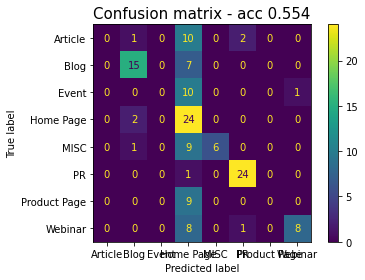


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        13
        Blog       0.79      0.68      0.73        22
       Event       0.00      0.00      0.00        11
   Home Page       0.31      0.92      0.46        26
        MISC       1.00      0.38      0.55        16
          PR       0.89      0.96      0.92        25
Product Page       0.00      0.00      0.00         9
     Webinar       0.89      0.47      0.62        17

    accuracy                           0.55       139
   macro avg       0.48      0.43      0.41       139
weighted avg       0.57      0.55      0.51       139



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [265]:
clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

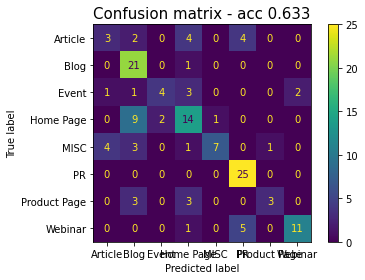


              precision    recall  f1-score   support

     Article       0.38      0.23      0.29        13
        Blog       0.54      0.95      0.69        22
       Event       0.67      0.36      0.47        11
   Home Page       0.52      0.54      0.53        26
        MISC       0.88      0.44      0.58        16
          PR       0.74      1.00      0.85        25
Product Page       0.75      0.33      0.46         9
     Webinar       0.85      0.65      0.73        17

    accuracy                           0.63       139
   macro avg       0.66      0.56      0.57       139
weighted avg       0.66      0.63      0.61       139



In [266]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced'
                                   ), 
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

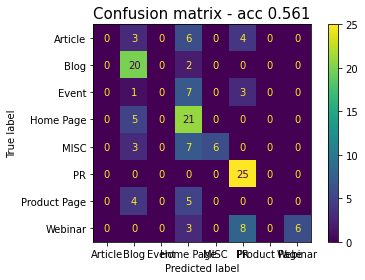


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        13
        Blog       0.56      0.91      0.69        22
       Event       0.00      0.00      0.00        11
   Home Page       0.41      0.81      0.55        26
        MISC       1.00      0.38      0.55        16
          PR       0.62      1.00      0.77        25
Product Page       0.00      0.00      0.00         9
     Webinar       1.00      0.35      0.52        17

    accuracy                           0.56       139
   macro avg       0.45      0.43      0.38       139
weighted avg       0.51      0.56      0.48       139



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [267]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced'
                                   ), 
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [268]:
labels_encoded

{'Home Page': 0,
 'Blog': 1,
 'MISC': 2,
 'Product Page': 3,
 'Event': 4,
 'Article': 5,
 'Webinar': 6,
 'PR': 7}

In [269]:
print_important_features(clf, features=5)

Class "0" - 5 most important features: ['clinical' 'trial' 'patient' 'iqvia' 'clinical trial']
Class "1" - 5 most important features: ['clinical' 'trial' 'iqvia' 'clinical trial' 'guest']
Class "2" - 5 most important features: ['clinical' 'patient' 'trial' 'iqvia' 'clinical trial']
Class "3" - 5 most important features: ['clinical' 'trial' 'patient' 'post' 'iqvia']
Class "4" - 5 most important features: ['content' 'email' 'post' 'trial' 'search']
Class "5" - 5 most important features: ['seo' 'guest' 'write' 'email' 'website']
Class "6" - 5 most important features: ['content' 'medable' 'iqvia' 'post' 'website']
Class "7" - 5 most important features: ['content' 'search' 'brand' 'seo' 'write']


In [270]:
misclassified_df = create_misclassified_df(X_test, y_test, y_pred)
misclassified_df

,lemmatized_cleaned_text,y_true,y_pred
246,url csscolon cascade style sheet url css funct...,5,0
210,Conversion Rate Optimization Digital Growth Co...,4,0
226,font display css Tricks font display property ...,2,0
169,discover B2B eCommerce Platform b2b ecommerce ...,3,0
490,good Practice Strategies make move modern ctm ...,6,7
...,...,...,...
308,2019 Amazon Consumer Behavior Report two third...,2,0
265,write Digital Photography School please check ...,2,0
235,powerful api Stack Data drive seo Tools datafo...,1,0
504,simplify transition dct part 2 3 simplify dece...,6,7


# 2. Word2Vec approach

In [44]:
# Deleting heavy variables no longer useful:
try:
  del X_train_tr
  del X_test_tr
except NameError:
  pass

In [45]:
from gensim.models import Word2Vec, KeyedVectors

In [46]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [47]:
w2v_model = KeyedVectors.load_word2vec_format(path, binary=True)

In [73]:
save_variable(w2v_model, 'w2v_model')

In [48]:
w2v_model.word_vec("test").shape

(300,)

In [49]:
print("Shape of embedding vector", w2v_model["Natural"].shape)
print("First 20 numbers in the embedding of the word Natural\n\n", w2v_model["Natural"][:20])

Shape of embedding vector (300,)
First 20 numbers in the embedding of the word Natural

 [-0.22753906 -0.07617188 -0.06787109 -0.1015625   0.20214844  0.12890625
  0.1796875  -0.11035156  0.01123047  0.01794434  0.12402344  0.11132812
 -0.3359375  -0.01104736 -0.16015625 -0.16113281 -0.13769531  0.4296875
 -0.03979492  0.05297852]


In [50]:
df_text

,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,4,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,2,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",2,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,1,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,5,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...
542,"Veeva Research Sites Forum, North America. Cli...",4,Veeva Research Sites Forum North America Clini...,"Veeva Research Sites Forum , North America . C...",Veeva Research Sites Forum North America Clini...,"veeva research sites forum , north america . c..."
543,Rethinking the Life Sciences Training Technolo...,6,Rethinking Life Sciences Training Technology E...,rethink the Life Sciences Training Technology ...,rethink Life Sciences Training Technology Ecos...,rethinking the life sciences training technolo...
544,Advancing Meaningful Remote Digital Endpoints ...,6,Advancing Meaningful Remote Digital Endpoints ...,advance Meaningful Remote Digital Endpoints fo...,advance Meaningful Remote Digital Endpoints Ra...,advancing meaningful remote digital endpoints ...
545,How Technology is Transforming Clinical Endpoi...,6,How Technology Transforming Clinical Endpoint ...,how Technology be Transforming Clinical Endpoi...,Technology Transforming Clinical Endpoint Adju...,how technology is transforming clinical endpoi...


In [51]:
list_of_lists = df_text['w2v_text'].str.split().tolist()

In [52]:
#Function that takes in the input text dataset in form of list of lists where each sentence is a list of words all the sentences are 
#inside a list
def embedding_feats(list_of_lists, DIMENSION, w2v_model):
    zeros_vector = np.zeros(DIMENSION)
    feats = []
    missing = set()
    missing_sentences = set()
    #Traverse over each sentence
    for tokens in tqdm(list_of_lists):
        # Initially assign zeroes as the embedding vector for the sentence
        feat_for_this = zeros_vector
        #Count the number of words in the embedding for this sentence
        count_for_this = 0
        #Traverse over each word of a sentence
        for token in tokens:
            #Check if the word is in the embedding vector
            if token in w2v_model:
                #Add the vector of the word to vector for the sentence
                feat_for_this += w2v_model[token]
                count_for_this +=1
            #Else assign the missing word to missing set just to have a look at it
            else:
                missing.add(token)
        #If no words are found in the embedding for the sentence
        if count_for_this == 0:
            #Assign all zeroes vector for that sentence
            feats.append(feat_for_this)
            #Assign the missing sentence to missing_sentences just to have a look at it
            missing_sentences.add(' '.join(tokens))
        #Else take average of the values of the embedding for each word to get the embedding of the sentence
        else:
            feats.append(feat_for_this/count_for_this)
    return feats, missing, missing_sentences

In [53]:
vectors, missing, missing_sentences = embedding_feats(list_of_lists, 300, w2v_model)

100%|██████████| 547/547 [00:01<00:00, 477.67it/s]


In [54]:
print("Shape of the final embeddings for the sentences", np.array(vectors).shape)
print("First 20 numbers in the embedding of the first train sentence\n\n", np.array(vectors)[0][:20])

Shape of the final embeddings for the sentences (547, 300)
First 20 numbers in the embedding of the first train sentence

 [ 0.01040277  0.04473038  0.02847395  0.11856265 -0.08779861  0.00149163
  0.04686172 -0.06999964  0.05312994  0.02903136 -0.07205876 -0.06800598
  0.01689928  0.03158497 -0.09863865  0.04592628  0.04565423  0.09702129
  0.01392149 -0.04904693]


In [55]:
len(vectors), vectors[0].shape

(547, (300,))

In [56]:
#Function for calculating roc auc with given actual binary values across target variables
#and the probability score made by the model
def accuracy(y_test, y_pred):
    aucs = []
    #Calculate the ROC-AUC for each of the target column
    for col in range(y_test.shape[1]):
        aucs.append(roc_auc_score(y_test[:,col],y_pred[:,col]))
    return aucs

In [57]:
from statistics import mean

In [58]:
vectors, missing, missing_sentences = embedding_feats(list_of_lists, 300, w2v_model)

100%|██████████| 547/547 [00:01<00:00, 432.88it/s]


In [59]:
y = df_text['label']
test_size = 0.2
random_state = 0

In [60]:
train_data, val_data, train_cats, val_cats = train_test_split(vectors, y, 
                                                              test_size=test_size,
                                                              stratify=y, 
                                                              random_state=random_state)

In [67]:
lr = LogisticRegression(max_iter=30000, 
                        class_weight='balanced'
                        ).fit(train_data, train_cats)

In [68]:
y_vals = val_cats

In [69]:
y_preds = lr.predict(val_data)

In [70]:
y_vals.value_counts()

0    26
6    19
1    17
2    16
4    15
3     9
5     8
Name: label, dtype: int64

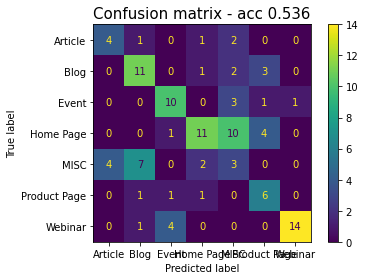

In [71]:
# Class weight balanced
print_confusion_matrix(y_vals, y_preds, with_report=False)

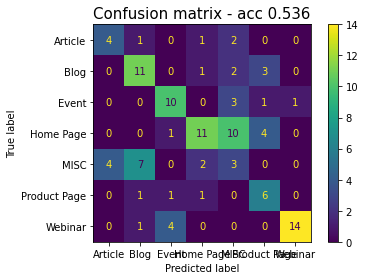

In [72]:
print_confusion_matrix(y_vals, y_preds, with_report=False)

# 3. BERT approach (anirban sen)

In [157]:
# Deleting heavy variables no longer useful:
try:
  del path, w2v_model
except NameError:
  pass

In [158]:
import urllib3
urllib3.__version__

'1.25.11'

In [ ]:
from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification, BertAdam
import torch
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from torch.nn import BCEWithLogitsLoss, Sigmoid

from tqdm.notebook import tqdm, trange

# from keras.preprocessing.sequence import pad_sequences

In [ ]:
df_text

,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,Write For Us. Want to Write for Us? Digital L...,MISC,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
1,"Write for Us. Yes, you. We’re always looking f...",MISC,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
2,FAQs for some new features available in the Be...,Blog,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
3,The Web Credibility Project. Our research in W...,Home Page,The Web Credibility Project Our research Web c...,the web Credibility Project . our research in ...,web Credibility Project research web credibili...,the web credibility project . our research in ...
4,Model DJs for Retail. DJPeoples is the nation’...,MISC,Model DJs Retail DJPeoples nations premier age...,Model dj for Retail . djpeople be the nation ’...,Model dj Retail djpeople nation premier agency...,model djs for retail . djpeoples is the nation...
...,...,...,...,...,...,...
293,Geniuz Media. The USPS is undoubtedly one of t...,Home Page,Geniuz Media The USPS undoubtedly one best cou...,Geniuz Media . the USPS be undoubtedly one of ...,Geniuz Media USPS undoubtedly one good courier...,geniuz media . the usps is undoubtedly one of ...
294,Submit Guest Post. Yes! We accept guest/Sponso...,MISC,Submit Guest Post Yes We accept guest Sponsore...,submit Guest Post . yes ! we accept guest / sp...,submit Guest Post yes accept guest sponsor pos...,submit guest post . yes ! we accept guest / sp...
295,Digital Marketing & Entrepreneurship Blog. Why...,MISC,Digital Marketing Entrepreneurship Blog Why wo...,Digital Marketing & Entrepreneurship Blog . wh...,Digital Marketing Entrepreneurship Blog would ...,digital marketing & entrepreneurship blog . wh...
296,"Real Estate, Fashion, Software, Travel. Write ...",MISC,Real Estate Fashion Software Travel Write us G...,"real Estate , Fashion , Software , Travel . wr...",real Estate Fashion Software Travel write guid...,"real estate , fashion , software , travel . wr..."


In [ ]:
# Cell 9
test_size = 0.2
random_state = 0

# Important cell # 9
column_used = 'w2v_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

# 3. 2nd BERT approach (Ashwin N)

## Encoding labels

In [271]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 36.5 MB/s 
     |████████████████████████████████| 132 kB 72.6 MB/s 
     |████████████████████████████████| 212 kB 64.0 MB/s 


In [272]:
from datasets import load_dataset

In [273]:
! pwd

/content/drive/MyDrive/url_classification


In [274]:
df_text.head(3)

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,4,Not provided,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,2,Not provided,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",2,Not provided,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."


In [275]:
df_text[['w2v_text', 'label']]

,w2v_text,label
0,2020 user summit . 2020 user summit * update...,4
1,write for us . want to write for us ? digita...,2
2,"write for us . yes , you . we ’re always looki...",2
3,faqs for some new features available in the be...,1
4,the best nootropic stack to replace adderall &...,5
...,...,...
686,do n’t ignore the sg in esg : why companies sh...,1
687,a seat on the idmp spor task force : karen har...,1
688,fierce pharma webinar . clinical operations an...,6
689,using nlp text mining in clinical research and...,6


In [276]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

In [277]:
df_text[TARGET].value_counts()

0    128
7    124
1    110
6     85
2     79
5     66
4     55
3     44
Name: label, dtype: int64

## Working with fixed validation data

### Preprocessing

In [278]:
# Cell 9
test_size = 0.15
random_state = 0

# Important cell # 9
column_used = 'w2v_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                    test_size=1/((1-test_size)/test_size),
                                                    stratify=y_train_val, 
                                                    random_state=random_state)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((483, 1), (104, 1), (104, 1), (483,), (104,), (104,))

In [279]:
y_train.value_counts()

0    90
7    86
1    77
6    59
2    55
5    46
4    39
3    31
Name: label, dtype: int64

In [280]:
y_val.value_counts()

7    19
0    19
1    17
6    13
2    12
5    10
4     8
3     6
Name: label, dtype: int64

In [281]:
y_test.value_counts()

7    19
0    19
1    16
6    13
2    12
5    10
4     8
3     7
Name: label, dtype: int64

In [282]:
# df_train = pd.concat([X_train, y_train], axis=1)
# df_val = pd.concat([X_val, y_val], axis=1)
# df_test = pd.concat([X_test, y_test], axis=1)

# df_train.shape, df_val.shape, df_test.shape

In [283]:
# train_path, val_path, test_path = 'bert_train.csv', 'bert_val.csv', 'bert_test.csv'
# df_train.to_csv(train_path, index=False)
# df_val.to_csv(val_path, index=False)
# df_test.to_csv(test_path, index=False)

In [284]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

dataset = DatasetDict({
    'train':Dataset.from_dict({'text': X_train[column_used],'label': y_train}),
    'validation':Dataset.from_dict({'text': X_val[column_used],'label': y_val}),
    'test':Dataset.from_dict({'text': X_test[column_used],'label': y_test})
    })

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 483
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 104
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 104
    })
})

In [285]:
train_ds = dataset['train']

In [286]:
print(train_ds[:5])

{'text': ['top digital marketing agency . thomas greenage   18:02 18 jul 22   when i started my program and new website with 1seo i was skeptical because i really did not know much about what they do other then an i.t. friend of mine recommended their services to help with my companies online presence and to build quote " an incredible website " . i must say after only a few months the phones and emails started to pick up and now we have literally had days when we can not keep up with the phones and emails i am very happy with the hard work that the team at 1seo are doing for my business and they are always happy to explain anything i may not totally understand . 1seo is hands down the best at what they do ! i look forward to a very long business relationship with 1seo!thank you 1seothomas j. greenagepresident of operationsa-1 electric', 'castor expands executive leadership team to scale clinical trial platform technology . hoboken , n.j.--(business wire)--castor , a leading provider o

In [287]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [288]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [289]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [290]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [291]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [292]:
print(tokenize(dataset["train"][:2])) 

{'input_ids': [[101, 2327, 3617, 5821, 4034, 1012, 2726, 2665, 4270, 2324, 1024, 6185, 2324, 21650, 2570, 2043, 1045, 2318, 2026, 2565, 1998, 2047, 4037, 2007, 1015, 3366, 2080, 1045, 2001, 18386, 2138, 1045, 2428, 2106, 2025, 2113, 2172, 2055, 2054, 2027, 2079, 2060, 2059, 2019, 1045, 1012, 1056, 1012, 2767, 1997, 3067, 6749, 2037, 2578, 2000, 2393, 2007, 2026, 3316, 3784, 3739, 1998, 2000, 3857, 14686, 1000, 2019, 9788, 4037, 1000, 1012, 1045, 2442, 2360, 2044, 2069, 1037, 2261, 2706, 1996, 11640, 1998, 22028, 2318, 2000, 4060, 2039, 1998, 2085, 2057, 2031, 6719, 2018, 2420, 2043, 2057, 2064, 2025, 2562, 2039, 2007, 1996, 11640, 1998, 22028, 1045, 2572, 2200, 3407, 2007, 1996, 2524, 2147, 2008, 1996, 2136, 2012, 1015, 3366, 2080, 2024, 2725, 2005, 2026, 2449, 1998, 2027, 2024, 2467, 3407, 2000, 4863, 2505, 1045, 2089, 2025, 6135, 3305, 1012, 1015, 3366, 2080, 2003, 2398, 2091, 1996, 2190, 2012, 2054, 2027, 2079, 999, 1045, 2298, 2830, 2000, 1037, 2200, 2146, 2449, 3276, 2007, 1015, 3

In [293]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [294]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 483
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 104
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 104
    })
})

In [295]:
from transformers import TFAutoModel 
tf_model = TFAutoModel.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [296]:
text = "this is a test"
inputs = tokenizer(text, return_tensors='tf')
inputs

{'input_ids': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[ 101, 2023, 2003, 1037, 3231,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [297]:
outputs = tf_model(inputs)
outputs

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 6, 768), dtype=float32, numpy=
array([[[-0.156513  , -0.18619666,  0.05277651, ..., -0.11881146,
          0.06620602,  0.5470156 ],
        [-0.3575139 , -0.6483559 , -0.0617902 , ..., -0.3040195 ,
          0.35076872,  0.5220684 ],
        [-0.27718496, -0.4459445 ,  0.1818425 , ..., -0.09477941,
         -0.00757464,  0.9958281 ],
        [-0.28408563, -0.3916768 ,  0.37525558, ..., -0.21505757,
         -0.11725189,  1.0526482 ],
        [ 0.2660821 , -0.509364  , -0.31801355, ..., -0.42029813,
          0.01444179, -0.21489467],
        [ 0.9440609 ,  0.01117263, -0.47139442, ...,  0.14394675,
         -0.7287836 , -0.16194907]]], dtype=float32)>, hidden_states=None, attentions=None)

In [298]:
outputs.last_hidden_state.shape

TensorShape([1, 6, 768])

In [299]:
dataset_encoded.reset_format()

def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(batch["text"], padding=True, 
                       truncation=True, return_tensors='tf')
    # Extract last hidden states
    outputs = tf_model(inputs)
     # Return vector for [CLS] token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

In [300]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=16)
dataset_hidden

  0%|          | 0/31 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 483
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 104
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 104
    })
})

In [301]:
import numpy as np
X_train_ = np.array(dataset_hidden["train"]["hidden_state"])
X_valid_ = np.array(dataset_hidden["validation"]["hidden_state"])
y_train_ = np.array(dataset_hidden["train"]["label"])
y_valid_ = np.array(dataset_hidden["validation"]["label"])
X_train_.shape, X_valid_.shape, y_train_.shape, y_valid_.shape

((483, 768), (104, 768), (483,), (104,))

In [302]:
X_test_ = np.array(dataset_hidden["test"]["hidden_state"])
y_test_ = np.array(dataset_hidden["test"]["label"])
X_test_.shape, y_test.shape

((104, 768), (104,))

In [303]:
X_train_

array([[ 0.05873385,  0.04719096,  0.10537522, ..., -0.16210385,
         0.56544811,  0.29709268],
       [-0.35427731, -0.20093302, -0.15492758, ..., -0.047068  ,
         0.42922249,  0.10642394],
       [-0.22879648,  0.08586603, -0.0200937 , ..., -0.13244587,
         0.420885  ,  0.24459372],
       ...,
       [ 0.02055306, -0.04405969, -0.13415915, ..., -0.08393468,
         0.33320674,  0.28182274],
       [-0.06648217, -0.12387978, -0.03101847, ...,  0.00210979,
         0.45029709,  0.17315535],
       [-0.0029561 , -0.05583599, -0.04098581, ..., -0.09463856,
         0.27491319,  0.23659591]])

In [304]:
X_valid_test_ = np.concatenate([X_valid_, X_test_])
X_valid_.shape, X_test_.shape, X_valid_test_.shape

((104, 768), (104, 768), (208, 768))

In [305]:
y_valid_test_ = np.concatenate([y_valid_, y_test_])
y_valid_.shape, y_test_.shape, y_valid_test_.shape

((104,), (104,), (208,))

### Modeling - machine learning approach:

In [306]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_, y_train_)
lr_clf.score(X_valid_test_, y_valid_test_)

0.7163461538461539

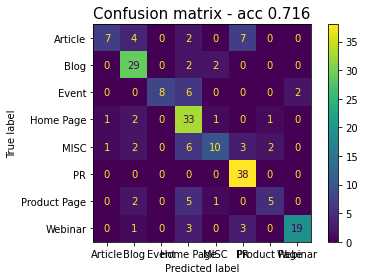


              precision    recall  f1-score   support

     Article       0.78      0.35      0.48        20
        Blog       0.72      0.88      0.79        33
       Event       1.00      0.50      0.67        16
   Home Page       0.58      0.87      0.69        38
        MISC       0.71      0.42      0.53        24
          PR       0.75      1.00      0.85        38
Product Page       0.62      0.38      0.48        13
     Webinar       0.90      0.73      0.81        26

    accuracy                           0.72       208
   macro avg       0.76      0.64      0.66       208
weighted avg       0.74      0.72      0.70       208



In [307]:
rf_clf = fit_model(RandomForestClassifier(max_depth=10,
                                            n_estimators=50,
                                            random_state=0,
                                          ),
                X_train_, 
                y_train_)

y_pred = predict(rf_clf, X_valid_test_)

print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

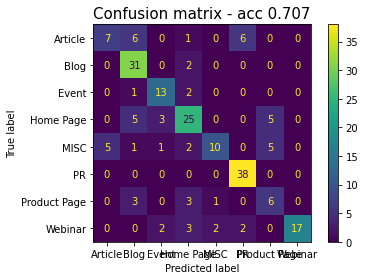


              precision    recall  f1-score   support

     Article       0.58      0.35      0.44        20
        Blog       0.66      0.94      0.78        33
       Event       0.68      0.81      0.74        16
   Home Page       0.66      0.66      0.66        38
        MISC       0.77      0.42      0.54        24
          PR       0.83      1.00      0.90        38
Product Page       0.38      0.46      0.41        13
     Webinar       1.00      0.65      0.79        26

    accuracy                           0.71       208
   macro avg       0.69      0.66      0.66       208
weighted avg       0.72      0.71      0.69       208



In [308]:
svc_clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_, 
                y_train_)

y_pred = predict(svc_clf, X_valid_test_)

print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

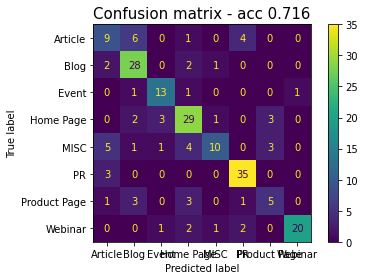


              precision    recall  f1-score   support

     Article       0.45      0.45      0.45        20
        Blog       0.68      0.85      0.76        33
       Event       0.72      0.81      0.76        16
   Home Page       0.69      0.76      0.72        38
        MISC       0.77      0.42      0.54        24
          PR       0.83      0.92      0.88        38
Product Page       0.45      0.38      0.42        13
     Webinar       0.95      0.77      0.85        26

    accuracy                           0.72       208
   macro avg       0.69      0.67      0.67       208
weighted avg       0.72      0.72      0.71       208



In [309]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced', 
                                   ), 
                X_train_, 
                y_train_)

y_pred = predict(lr_clf, X_valid_test_)

print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

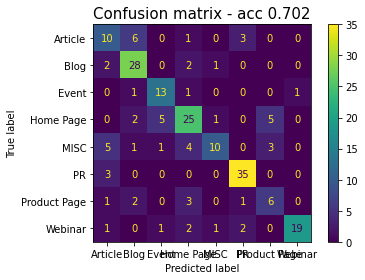


              precision    recall  f1-score   support

     Article       0.45      0.50      0.48        20
        Blog       0.70      0.85      0.77        33
       Event       0.65      0.81      0.72        16
   Home Page       0.66      0.66      0.66        38
        MISC       0.77      0.42      0.54        24
          PR       0.85      0.92      0.89        38
Product Page       0.43      0.46      0.44        13
     Webinar       0.95      0.73      0.83        26

    accuracy                           0.70       208
   macro avg       0.68      0.67      0.67       208
weighted avg       0.72      0.70      0.70       208



In [310]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced', 
                                   ), 
                X_train_, 
                y_train_)

y_pred = predict(lr_clf, X_valid_test_)

print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

### Modeling - deep learning approach:

In [293]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [294]:
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [295]:
# The column names to convert to TensorFlow tensors
from transformers import DataCollatorWithPadding
from transformers import DataCollatorForTokenClassification
from transformers import DefaultDataCollator


tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 16

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DefaultDataCollator(return_tensors="tf")


tf_train_dataset = dataset_encoded["train"].to_tf_dataset(columns=tokenizer_columns, 
                                                           label_cols=["label"], shuffle=True,
                                                           batch_size=batch_size,
                                                           collate_fn=data_collator
                                                          )
tf_eval_dataset = dataset_encoded["validation"].to_tf_dataset(columns=tokenizer_columns, 
                                                               label_cols=["label"], shuffle=False,
                                                               batch_size=batch_size,
                                                               collate_fn=data_collator
                                                              )

tf_train_dataset

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [296]:
tf_test_dataset = dataset_encoded["test"].to_tf_dataset(columns=tokenizer_columns, 
                                                               label_cols=["label"], shuffle=False,
                                                               batch_size=batch_size,
                                                               collate_fn=data_collator
                                                              )

In [297]:
num_labels = len(y_train.value_counts())

In [298]:
from transformers import TFAutoModelForSequenceClassification
tf_model = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_38', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [299]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

epochs = 100
patience = 3

tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=tf.metrics.SparseCategoricalAccuracy()
)

callback = EarlyStopping(monitor='val_loss',
                          patience=patience,
                          restore_best_weights=True)

tf_model.fit(tf_train_dataset, 
             validation_data=tf_eval_dataset, 
             epochs=epochs,
             callbacks=[callback]
             )

Epoch 1/100
 1/31 [..............................] - ETA: 37:01 - loss: 2.0554 - sparse_categorical_accuracy: 0.1875

KeyboardInterrupt: ignored

In [ ]:
# tf_model.fit(tf_train_dataset, 
#              validation_data=tf_eval_dataset, 
#              epochs=epochs,
#              callbacks=[callback]
#              )

In [ ]:
tf.keras.models.save_model(tf_model, filepath='my_model', overwrite=True, save_format='tf')

In [ ]:
tf_model2 = tf.keras.models.load_model(filepath='my_model') 
# why doesn't it work when running the next cell with the loaded model?

In [ ]:
loss, train_accuracy = tf_model.evaluate(tf_train_dataset)
print("Loss: {}\t Train Accuracy: {}".format(loss, train_accuracy))

In [ ]:
loss, eval_accuracy = tf_model.evaluate(tf_eval_dataset)
print("Loss: {}\t Eval Accuracy: {}".format(loss, eval_accuracy))

In [ ]:
loss, test_accuracy = tf_model.evaluate(tf_test_dataset)
print("Loss: {}\t Test Accuracy: {}".format(loss, test_accuracy))

In [ ]:
output_logits = tf_model.predict(tf_test_dataset).logits
pred_labels = np.argmax(output_logits, axis=-1)

In [ ]:
pred_labels

In [ ]:
print_confusion_matrix(y_test, pred_labels, with_report=True)

In [ ]:
labels_encoded

## Working with validation split

In [ ]:
# Cell 9
test_size = 0.2
random_state = 0

# Important cell # 9
column_used = 'w2v_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
dataset = DatasetDict({
    'train':Dataset.from_dict({'text': X_train[column_used],'label': y_train}),
    'test':Dataset.from_dict({'text': X_test[column_used],'label': y_test})
    })

dataset

In [ ]:
train_ds = dataset['train']

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

dataset_encoded

tf_model = TFAutoModel.from_pretrained(model_ckpt)

dataset_encoded.reset_format()

def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(batch["text"], padding=True, 
                       truncation=True, return_tensors='tf')
    # Extract last hidden states
    outputs = tf_model(inputs)
     # Return vector for [CLS] token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=16)
dataset_hidden

X_train_ = np.array(dataset_hidden["train"]["hidden_state"])
y_train_ = np.array(dataset_hidden["train"]["label"])

X_train_.shape, y_train_.shape

In [ ]:
X_test_ = np.array(dataset_hidden["test"]["hidden_state"])
y_test_ = np.array(dataset_hidden["test"]["label"])

In [ ]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_, y_train_)
lr_clf.score(X_test_, y_test_)

In [ ]:
rf_clf = fit_model(RandomForestClassifier(max_depth=10,
                                            n_estimators=50,
                                            random_state=0,
                                          ),
                X_train_, 
                y_train_)

y_test_pred = predict(rf_clf, X_test_)

print_confusion_matrix(y_test, y_test_pred, with_report=True)

In [ ]:
svc_clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_, 
                y_train_)

y_test_pred = predict(svc_clf, X_test_)

print_confusion_matrix(y_test, y_test_pred, with_report=True)

In [ ]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced', 
                                   ), 
                X_train_, 
                y_train_)

y_test_pred = predict(lr_clf, X_test_)

print_confusion_matrix(y_test, y_test_pred, with_report=True)

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

In [ ]:
dataset_encoded

In [ ]:
# The column names to convert to TensorFlow tensors
from transformers import DataCollatorWithPadding
from transformers import DataCollatorForTokenClassification
from transformers import DefaultDataCollator


tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 16

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DefaultDataCollator(return_tensors="tf")


tf_train_dataset = dataset_encoded["train"].to_tf_dataset(columns=tokenizer_columns, 
                                                           label_cols=["label"], shuffle=True,
                                                           batch_size=batch_size,
                                                           collate_fn=data_collator
                                                          )

tf_train_dataset

In [ ]:
tokenizer_columns

In [ ]:
dataset_encoded["train"]['input_ids', 'attention_mask']

In [ ]:
tf_test_dataset = dataset_encoded["test"].to_tf_dataset(columns=tokenizer_columns, 
                                                               label_cols=["label"], shuffle=False,
                                                               batch_size=batch_size,
                                                               collate_fn=data_collator
                                                              )

In [ ]:
tf_model_vs = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

In [ ]:
tf_train_array = np.array(tf_train_dataset)

In [ ]:
tf_train_dataset

In [ ]:
tf_train_array

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

epochs = 100
patience = 3
validation_split = 0.15

tf_model_vs.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=tf.metrics.SparseCategoricalAccuracy()
)

callback = EarlyStopping(monitor='val_loss',
                          patience=patience,
                          restore_best_weights=True)

tf_model_vs.fit(tf_train_array, 
             validation_split=validation_split, 
             epochs=epochs,
             callbacks=[callback]
             )